In [1]:
import os 
data_folder = "braintumors"
data_folder_yolo = data_folder + "_yolo"
data_folder_coco = data_folder + "_coco"
folders = os.listdir("braintumors")
print(folders)

['sagittal_t1wce_2_class', 'axial_t1wce_2_class', 'coronal_t1wce_2_class']


In [2]:
!tree braintumors/ -d 
# the -d option is to show directories only 

braintumors/
├── axial_t1wce_2_class
│   ├── images
│   │   ├── test
│   │   └── train
│   └── labels
│       ├── test
│       └── train
├── coronal_t1wce_2_class
│   ├── images
│   │   ├── test
│   │   └── train
│   └── labels
│       ├── test
│       └── train
└── sagittal_t1wce_2_class
    ├── images
    │   ├── test
    │   └── train
    └── labels
        ├── test
        └── train

21 directories


In [3]:
# perpares a helper to count the number of images and labels from a dataset with the YOLO annotation format 
from glob import glob 
def count_yolo_data(folder):
    for images_labels in ["images","labels"]:
        for train_test in ["train","test"]:
            file_ext = "*.jpg" if images_labels=="images" else "*.txt"
            p = os.path.join(folder,images_labels,train_test,file_ext)
            files = glob(p)
            print(train_test,images_labels,len(files))

In [4]:
# count the number of images and labels in each of the three folders 
for folder in folders:
    print("-"*8 + folder+"-"*8)
    folder = os.path.join(data_folder,folder)
    count_yolo_data(folder)


--------sagittal_t1wce_2_class--------
train images 264
test images 70
train labels 264
test labels 70
--------axial_t1wce_2_class--------
train images 310
test images 75
train labels 296
test labels 75
--------coronal_t1wce_2_class--------
train images 319
test images 78
train labels 318
test labels 78


In [5]:
import os 
import shutil
from tqdm import tqdm
#move all into one folder 
def copy_yolo_files(from_folder,to_folder,images_labels,train_test):
    from_path = os.path.join(from_folder,images_labels,train_test)
    to_path = os.path.join(to_folder,images_labels,train_test)
    os.makedirs(to_path,exist_ok=True)
    #get files 
    file_ext = "*.jpg" if images_labels =="images" else "*.txt"
    files = glob(os.path.join(from_path,file_ext))
    ##move files 
    for file in tqdm(files):
        shutil.copy(file,to_path)

In [6]:
# Combines images from three folders into one 
for from_folder in folders:
    from_folder = os.path.join(data_folder,from_folder)
    to_folder = data_folder_yolo
    for images_labels in ["images","labels"]:
        for train_test in ["train","test"]:
            copy_yolo_files(from_folder,to_folder,images_labels,train_test)

100%|██████████| 78/78 [00:00<00:00, 1878.63it/s]


In [7]:
# Now the folder should look like 
!tree - d {data_folder_yolo}

-  [error opening dir]
d  [error opening dir]
braintumors_yolo
├── classes.txt
├── images
│   ├── test
│   │   ├── 00000_102.jpg
│   │   ├── 00000_121.jpg
│   │   ├── 00000_140.jpg
│   │   ├── 00000_159.jpg
│   │   ├── 00002_110.jpg
│   │   ├── 00002_129.jpg
│   │   ├── 00002_147.jpg
│   │   ├── 00002_166.jpg
│   │   ├── 00003_154.jpg
│   │   ├── 00003_173.jpg
│   │   ├── 00003_192.jpg
│   │   ├── 00003_211.jpg
│   │   ├── 00005_106.jpg
│   │   ├── 00005_125.jpg
│   │   ├── 00005_143.jpg
│   │   ├── 00006_137.jpg
│   │   ├── 00006_156.jpg
│   │   ├── 00006_174.jpg
│   │   ├── 00006_192.jpg
│   │   ├── 00006_210.jpg
│   │   ├── 00008_178.jpg
│   │   ├── 00009_110.jpg
│   │   ├── 00009_184.jpg
│   │   ├── 00011_277.jpg
│   │   ├── 00012_181.jpg
│   │   ├── 00017_187.jpg
│   │   ├── 00018_101.jpg
│   │   ├── 00018_109.jpg
│   │   ├── 00018_111.jpg
│   │   ├── 00018_117.jpg
│   │   ├── 00018_121.jpg
│   │   ├── 00018_126.jpg
│   │   ├── 00018_134.jpg
│   │   ├── 00019_66.jpg
│   │   ├── 00

In [8]:
count_yolo_data(data_folder_yolo)

train images 893
test images 223
train labels 878
test labels 223


In [9]:
# The current YOLO datasets store the metadata (class labels and so on) in a .yaml file. It's Simpler to extract this and keep the classes in classes.txt for the newly created YOLO dataset using the following code snippets
import yaml 
from yaml.loader import SafeLoader 
with open(os.path.join(data_folder,folders[0],folders[0]+'.yaml')) as f:
    classes = yaml.load(f,Loader=SafeLoader)["names"]
with open(os.path.join(data_folder_yolo,"classes.txt"),"w") as f:
    f.write("\n".join(classes))

In [10]:
# Now we are ready to conver the dataset into COCO format 
from pylabel import importer
def yolo_to_coco(input_folder,output_folder,train_test):
    labels_path = os.path.join(input_folder,"labels",train_test)
    images_path = os.path.join(input_folder,"images",train_test)
    coco_dir = os.path.join(output_folder,train_test)
    os.makedirs(coco_dir,exist_ok=True)
    
    txt_files = glob(os.path.join(labels_path,"*.txt"))
    img_files = glob(os.path.join(images_path,"*.jpg"))
    #copy annotations 
    for f in tqdm(txt_files):
        shutil.copy(f,coco_dir)
    #copy images
    for f in tqdm(img_files):
        shutil.copy(f,coco_dir)
    #get the classes 
    with open(os.path.join(input_folder,"classes.txt"),"r") as f:
        classes = f.read().split("\n")
    #load dataset 
    dataset = importer.ImportYoloV5(path=coco_dir,cat_names=classes,name="brain tumors")
    #export 
    coco_file = os.path.join(coco_dir,"_annotations.coco.json")
    #Detectron requires starting index from 1 
    dataset.export.ExportToCoco(coco_file,cat_id_index=1)
    #Now delete yolo annotations in coco set 
    for f in txt_files:
        os.remove(f.replace(labels_path,coco_dir))
    

In [11]:
yolo_to_coco(data_folder_yolo,data_folder_coco,"train")
yolo_to_coco(data_folder_yolo,data_folder_coco,"test")

Exporting to COCO file...: 100%|██████████| 241/241 [00:00<00:00, 2396.30it/s]


In [12]:
!tree -d {data_folder_coco}

braintumors_coco
├── test
└── train

2 directories


In [13]:
from detectron2.data.datasets import register_coco_instances 
#Some configurations
name_ds = "braintumors_coco"
name_ds_train = name_ds+"_train"
name_ds_test = name_ds+"_test"
image_root_train = name_ds + "/train"
image_root_test = name_ds + "/test"
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af
json_file_test = name_ds + "/test/" + af 
#Register datasets
### Train dataset 
register_coco_instances(name=name_ds_train,
                        metadata={},
                        json_file=json_file_train,
                        image_root=image_root_train)
### test dataset 
register_coco_instances(
    name= name_ds_test,
    metadata={},
    json_file = json_file_test,
    image_root = image_root_test
)

In [14]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import random 
random.seed(2)
import cv2
import matplotlib.pyplot as plt 
def plot_random_samples(name_ds,n=3):
    #access
    ds = DatasetCatalog.get(name_ds)
    met = MetadataCatalog.get(name_ds)
    #plot (arrange in 3x3)
    nrows = int(-(-n/3)) #ceil 
    ncols = 3 
    fig,axs = plt.subplots(nrows,ncols,figsize=(15,5))
    for i,s in enumerate(random.sample(ds,n)):
        ax = axs[i//ncols][i%ncols] if len(axs.shape)==2 else axs[i]
        img = cv2.imread(s["file_name"])
        v = Visualizer(img[:,:,::-1],metadata=met,scale=0.5)
        v = v.draw_dataset_dict(s)
        ax.imshow(v.get_image())
        ax.axis("off")
    plt.tight_layout()
    plt.show()

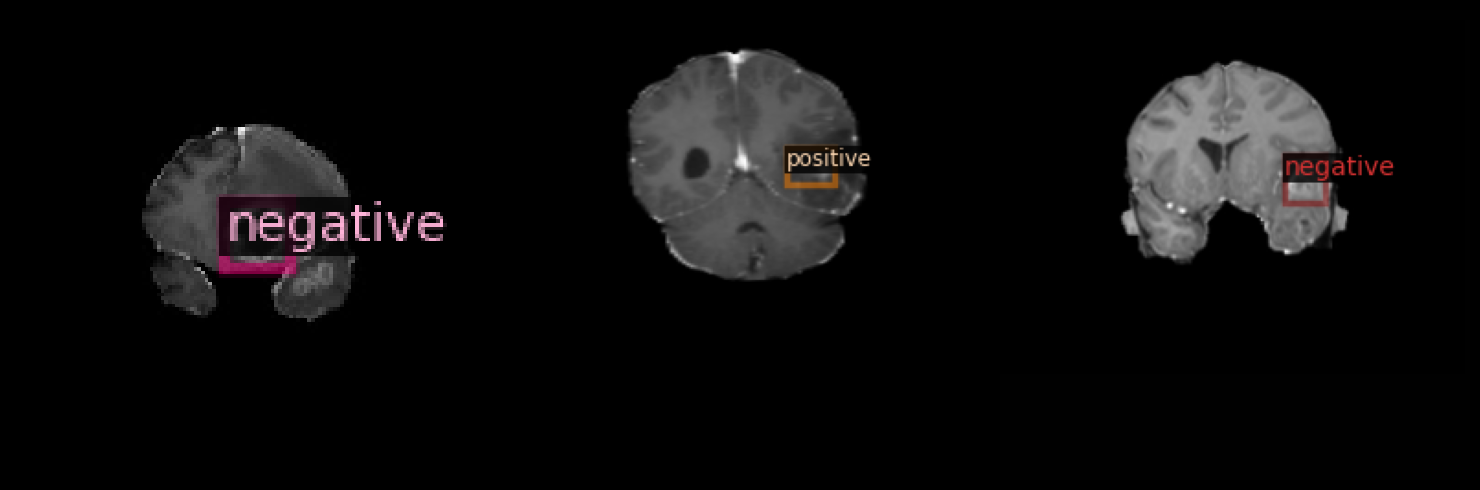

In [15]:
plot_random_samples(name_ds_train,n=3)

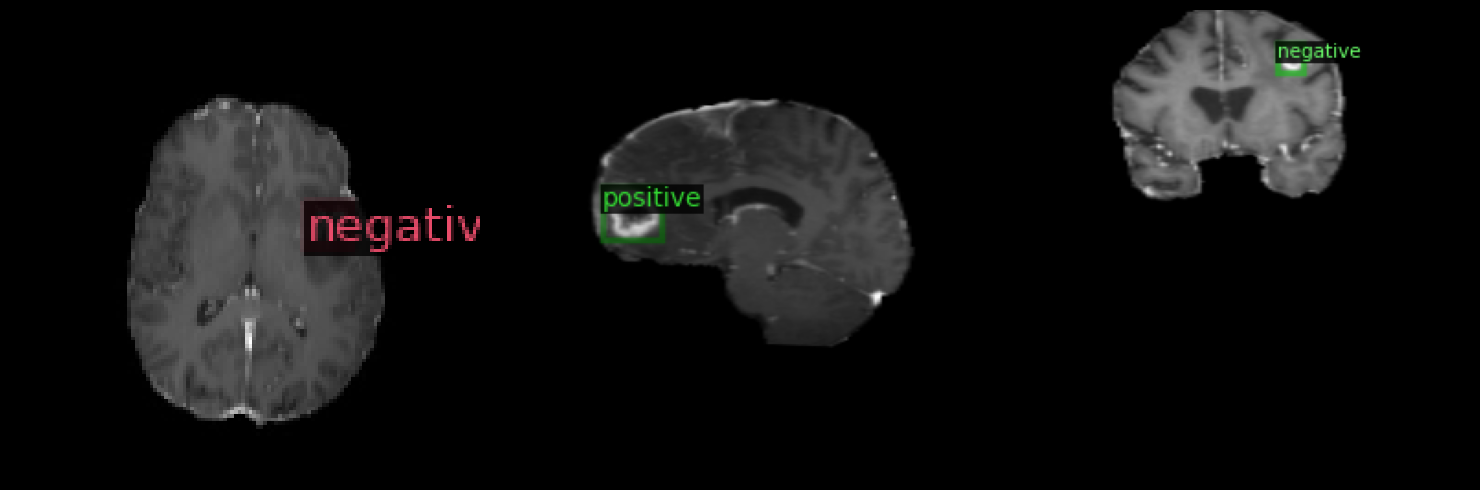

In [16]:
plot_random_samples(name_ds_test,n=3)

# Uing the default trainer 

In [17]:
from detectron2.utils.logger import setup_logger
logger = setup_logger()

In [18]:
import os 
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle

output_dir = "output/object_detector"
os.makedirs(output_dir,exist_ok=True)
output_cfg_path = os.path.join(output_dir,"cfg.pickle")
nc = 2
device = "cuda"
config_file_url = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
checkpoint_url = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"

In [19]:
#Create a configuration file 
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
#Download weights
cfg.DATASETS.TRAIN = (name_ds_train,)
cfg.DATASETS.TEST  = (name_ds_test,)
#Workers
cfg.DATALOADER.NUM_WORKERS = nc
#Images per batch 
cfg.SOLVER.IMS_PER_BATCH = 1
#Learning Rate 
cfg.SOLVER.BASE_LR = 0.00025  #! set a relatively small learning rate because we are doing trans
#Iterations 
cfg.SOLVER.MAX_ITER = 5000 
cfg.SOLVER.CHECKPOINT_PERIOD  = 500 
#Classes 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc 
cfg.MODEL.DEVICE = device 
cfg.OUTPUT_DIR = output_dir

In [20]:
#Save configuration file for future use 
with open(output_cfg_path,"wb") as f:
    pickle.dump(cfg,f,protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
from detectron2.engine import DefaultTrainer
trainer = DefaultTrainer(cfg)
trainer.train()

[04/25 01:56:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/home/kareem/mambaforge/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/25 01:57:01 d2.utils.events]:  eta: 0:46:05  iter: 19  total_loss: 1.8  loss_cls: 1.096  loss_box_reg: 1.443e-05  loss_rpn_cls: 0.7003  loss_rpn_loc: 0.004299    time: 0.5750  last_time: 0.5600  data_time: 0.0150  last_data_time: 0.0015   lr: 4.9953e-06  max_mem: 3065M
[04/25 01:57:13 d2.utils.events]:  eta: 0:46:34  iter: 39  total_loss: 1.738  loss_cls: 1.026  loss_box_reg: 2.092e-05  loss_rpn_cls: 0.6996  loss_rpn_loc: 0.008633    time: 0.5730  last_time: 0.6147  data_time: 0.0028  last_data_time: 0.0033   lr: 9.9902e-06  max_mem: 3267M
[04/25 01:57:25 d2.utils.events]:  eta: 0:46:37  iter: 59  total_loss: 1.6  loss_cls: 0.8898  loss_box_reg: 1.632e-05  loss_rpn_cls: 0.6981  loss_rpn_loc: 0.004202    time: 0.5777  last_time: 0.4828  data_time: 0.0029  last_data_time: 0.0025   lr: 1.4985e-05  max_mem: 3267M
[04/25 01:57:37 d2.utils.events]:  eta: 0:49:34  iter: 79  total_loss: 1.427  loss_cls: 0.7249  loss_box_reg: 1.709e-05  loss_rpn_cls: 0.6962  loss_rpn_loc: 0.005324    time: 

KeyboardInterrupt: 

the output includes the configuration file (cfg.pickle) a file for log events, the last checkpoint so the  model can 
reusme its training if needed, a file for all the training evalution metrics (metrics.json) and all the models at every 500 iterations . the model last iteration (cfg.SOLVER.MAX_ITERATIONS) is stored as model_final.pth 
# mAP 
IoU is computed as the ratio of the overlapping region between the predicted bounding box and the ground-truth boudning box. these two boxes are consdiered the same if the IoU value is greater than or equal to 0.5,for each class label,we compute the average precision (AP) values for different recall values finally mean AP (mAP)value across different class categories is the mAP@0.5 evlaution metric. Therefore,this measurement is robust and helps to select a model that should scale well to the unseen datasets. 


In [23]:
model_names = []
max_iter = cfg.SOLVER.MAX_ITER
chp = cfg.SOLVER.CHECKPOINT_PERIOD
for i in range(1,max_iter//chp):
    model_names.append(f"model_{str(i*chp-1).zfill(7)}.pth")
model_names.append("model_final.pth")
print(model_names)

['model_0000499.pth', 'model_0000999.pth', 'model_0001499.pth', 'model_0001999.pth', 'model_0002499.pth', 'model_0002999.pth', 'model_0003499.pth', 'model_0003999.pth', 'model_0004499.pth', 'model_final.pth']


In [24]:
from detectron2.engine import DefaultPredictor 
from detectron2.evaluation import COCOEvaluator

evaluator = COCOEvaluator(
    dataset_name = name_ds_test,
    tasks=("bbox",),
    distributed=False,
    output_dir=os.path.join(output_dir,"test_results")
)

[04/25 02:30:51 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.


Notably, COCOEvaluator is selected because the dataset is in COCO format. Additionally, the "bbox"
input for the tasks option indicates to the evaluator to perform evaluations for object detection tasks.
The test results are stored in the 'test_results' folder under the output directory.

In [25]:
#evaluate all folders
import logging
logger.setLevel(logging.CRITICAL)
model_eval_results = []
for model_name in model_names:
    #load weights
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,model_name)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
    #predictor 
    predictor = DefaultPredictor(cfg)
    #evaluate
    x = trainer.test(cfg,predictor.model,evaluators=[evaluator])
    model_eval_results.append(x["bbox"])

AssertionError: Checkpoint output/object_detector/model_0000999.pth not found!

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (10).

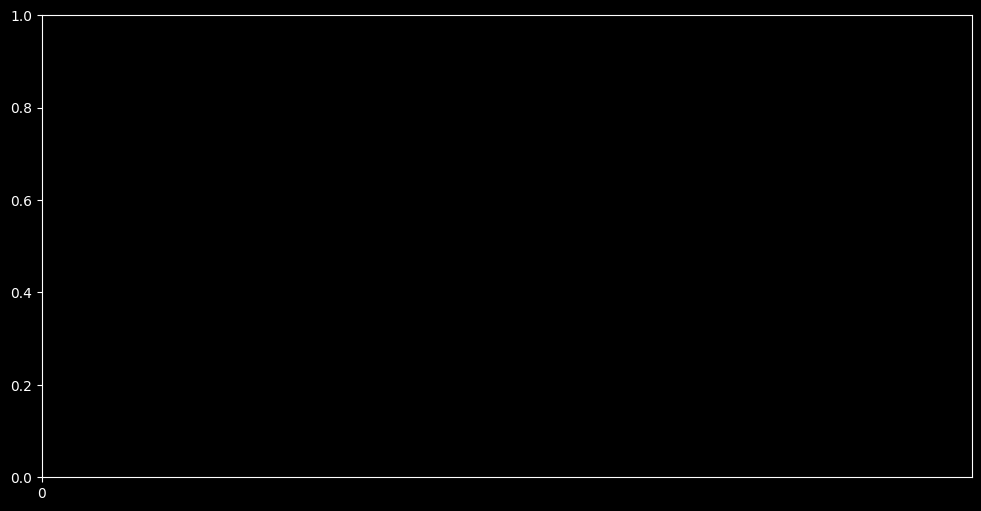

In [27]:
import math 
import numpy as np 
import matplotlib.pyplot as plt 

aps = [x["AP50"] if not math.isnan(x["AP50"]) else 0 for x in model_eval_results]
best_model_idx = np.argmax(aps)
best_model_name = model_names[best_model_idx]
best_ap = aps[best_model_idx]
anno_test = f"The best model {best_model_name} has mAP@0.5 = {round(best_ap,2)}"

plt.figure(figsize=(12,6))
x = [i for i in range(len(aps))]
y = aps
plt.xticks(ticks=x,labels=model_names,rotation=45)
plt.plot(x,y)
plt.scatter(x,y)
plt.plot([best_model_idx,best_model_idx],[0,best_ap],"--")
plt.ylabel("mAP@0.5")
plt.text(best_model_idx+0.1,best_ap,anno_test,ha="left",va="center")
plt.show()


# Choosing a confidence threshold 
The following code snippets evaluates the impact of this confidence threshold for the selected model 

In [ ]:
thresh_tests = [0.1*i for i in range(10)]
thresh_eval_results = []
for thresh_test in thresh_tests:
    #load weights
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,best_model_name)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thresh_test 
    #predictor 
    predictor = DefaultPredictor(cfg)
    #evaluate 
    x = trainer.test(cfg,predictor.model,evaluators=[evaluator])
    thresh_eval_results.append(x["bbox"])

Generally,reducing the confidence threshold brings more recalls with fewer precisions and leads to having higher mAP@0.5
However,a smaller threshold also makes the inference slower(due to having many regions of interset before going through the NMS process)


In [28]:
aps = [x['AP50'] if not math.isnan(x['AP50']) else 0 for x in thresh_eval_results]
best_thresh_idx = np.argmax(aps)
best_thresh = thresh_tests[best_thresh_idx]
best_ap = aps[best_thresh_idx]
anno_text = f'The best confidence threshold of {best_thresh} has mAP@0.5={round(best_ap, 2)}'

plt.figure(figsize=(12, 6))
x = [round(x, 2) for x in thresh_tests]
y = aps
plt.plot(x, y)
plt.scatter(x, y)
plt.xticks(ticks=thresh_tests, labels=x)
plt.plot([best_thresh, best_thresh], [0, best_ap], '--')
plt.xlabel("Confidence thresholds (cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)")
plt.ylabel("mAP@0.5")
plt.text(best_thresh+0.01, best_ap+1, anno_text, ha="left", va="center")
plt.show()

NameError: name 'thresh_eval_results' is not defined

In [ ]:
import random
random.seed(42)
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


def plot_random_samples(name_ds, n=3, predictor=None):
    # access
    ds = DatasetCatalog.get(name_ds)
    met = MetadataCatalog.get(name_ds)
    nrows = int(-(-n/3)) # ceil
    ncols = 3
    samples = random.sample(ds, n)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(21, 7))
    for i,s in enumerate(samples):
        ax = axs[i//ncols][i%ncols] if len(axs.shape) == 2 else axs[i]
        img = cv2.imread(s["file_name"])
        v = Visualizer(img[:,:, ::-1], metadata=met, scale=0.5)
        # visualize ground-truths
        v = v.draw_dataset_dict(s)
        ax.imshow(v.get_image())
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(21, 7))
    for i,s in enumerate(samples):
      ax = axs[i//ncols][i%ncols] if len(axs.shape) == 2 else axs[i]
      img = cv2.imread(s["file_name"])
      # predict
      outputs = predictor(img)
      # visualize prediction results
      v = Visualizer(img[:,:, ::-1], metadata=met, scale=0.5)
      
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      ax.imshow(v.get_image())
      ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
#best model 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,best_model_name)
predictor = DefaultPredictor(cfg)

In [ ]:
plot_random_samples(name_ds_test,predictor=predictor)

# Developing a custom trainer 


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
class BrainTumorTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls,cfg,dataset_name,output_folder=None):
        if output_folder ==None:
            output_folder = cfg.OUTPUT_DIR 
        else:
            output_folder = os.path.join(cfg.OUTPUT_DIR,output_folder)
        os.makedirs(output_folder)
    return COCOEvaluator(dataset_name,distributed=False,output_dir = output_folder)


this custom trainer overrides the build_evaluator method to return an object of COCOEValuator that can be evaluate the test set. The COCOEvaluator class is chosen because the test dataset is in COCO format. when the evaluator is specified,the following code snippet specifies the frequency of how often this evaluator is executed


In [30]:
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD 

In [ ]:
trainer = BrainTumorTrainer(cfg)
trainer.train()

# Utilizing the hook System 
A hook system allows incorporating classes to execute several tasks on training events. A custom hook builds upon inheriting a base class from detectorn2 called detectron2.engine.HookBase 
a hook allows the developer to execute tasks on four events by overriding the following methods:
1. before_training() : to include tasks to be executed before the first training iteration 
2. after_training(): to include tasks to be executed after training completes
3. before_step(): to include tasks to be executed before each training iteration 
4. after_step(): to inlcude tasks to be executed after each training iteration 

The following code snippet creates a hook to read the evaluation metrics generated by COCOEvaluator
from the previously built custom trainer, keeps track of the best model with the highest mAP@0.5
value, and saves the model as model_best.pth:

In [ ]:
from detectron2.engine.hooks import HookBase
import torch
import logging

class BestModelHook(HookBase):
    def __init__(self,cfg,metric="bbox/AP50",min_max="max"):
        self.period  = cfg.TEST.EVAL_PERIOD
        self.metric = metric
        self.min_max = min_max
        self.best_value = float("-inf") if min_max =="max" else float("inf")
        logger = logging.getLogger("detectron2")
        logger.setLevel(logging.DEBUG )
        logger.propagate = False
        self._logger = logger 
        
        def _take_latest_metrics(self):
            with torch.no_grad():
                latest_metrics = self.trainer.storage.latest()
                return latest_metrics
        def after_step(self):
            next_iter = self.trainer.iter + 1
            is_final = next_iter ==self.trainer.max_iter
            if is_final or (self._period >0 and next_iter %self._period ==0):
                latest_metrics = self._take_latest_metrics()
                for(key,(value,iter)) in latest_metrics.items():
                    if key ==self.metric:
                        if(self.min_max=="min" and value <self.best_value) or (self.min_max =="max" and value>self.best_value):
                            self._logger.info("Updating best model at iteration {} with {} = {}".format(iter,self.metric,value))
                            self.best_value = value 
                            self.trainer.checkpointer.save("model_best")
        

the hook is build by overriding the after_step() method. However, it only performs its tasks at every cfg.TEST.EVAL_PERIOD iteration when there are results from COCOEvaluator 

In [ ]:
trainer = BrainTumorTrainer(cfg)
bm_hook = BestModeHook(cfg,metric="bbox/AP50",min_max="max")
trainer.register_hooks(hooks=[bm_hook])
trainer.train()